In [106]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate

from scipy.interpolate import interp1d
from numpy.polynomial.polynomial import Polynomial
from sklearn.ensemble import RandomForestRegressor

In [107]:
trainFeatures = pd.read_csv('data/train_features.csv')
testFeatures = pd.read_csv('data/test_features.csv')
trainLabels = pd.read_csv('data/train_labels.csv')
example = pd.read_csv('data/submission_format.csv')

In [108]:
trainFeatures.head()

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
0,1979,Sarjana,Rencana Menikah,NaN,0.0,1.0,NaN,50575.0,260967.0,50575.0,20230.0,2.0,2.0,5.0,0.0,2014-05-05
1,1950,Sarjana,Rencana Menikah,84063000.0,NaN,NaN,70.0,6069.0,44506.0,80920.0,20230.0,9.0,6.0,4.0,0.0,2013-03-17
2,1966,Sarjana,Menikah,127532564.0,0.0,0.0,45.0,117611.0,265460.0,96341.0,145573.0,1.0,1.0,7.0,0.0,NaN
3,1961,Magister,Rencana Menikah,165579620.0,0.0,0.0,90.0,206346.0,1613901.0,27725.0,125868.0,0.0,7.0,8.0,0.0,NaN
4,1970,Sarjana,Rencana Menikah,117703159.0,1.0,1.0,78.0,90563.0,311757.0,40358.0,33875.0,7.0,6.0,5.0,0.0,NaN


In [109]:
trainFeatures.shape

(3817, 16)

In [110]:
testFeatures.head()

,ID,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
0,2241,1957,Sarjana,NaN,120660151.0,0.0,1.0,63.0,122277.0,541399.0,214192.0,84305.0,4.0,6.0,10.0,0.0,NaN
1,2274,1968,Doktor,Menikah,163551821.0,0.0,1.0,58.0,35761.0,353335.0,63365.0,41112.0,2.0,5.0,10.0,0.0,NaN
2,1107,1968,SMA,Menikah,29857000.0,0.0,0.0,34.0,8092.0,22253.0,30345.0,26299.0,2.0,0.0,5.0,0.0,2013-08-06
3,4478,1971,Doktor,Menikah,117949098.0,0.0,1.0,82.0,4872.0,126061.0,0.0,9745.0,3.0,5.0,7.0,0.0,NaN
4,5080,1974,Sarjana,Rencana Menikah,164761134.0,0.0,0.0,28.0,343208.0,1416462.0,236196.0,107776.0,0.0,1.0,8.0,0.0,NaN


In [111]:
example.head()

,ID,jumlah_promosi
0,2241,6
1,2274,6
2,1107,6
3,4478,6
4,5080,6


# Data Assessing

## Informasi Umum Dataset Train Features

In [112]:
trainFeatures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3817 entries, 0 to 3816
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tahun_kelahiran          3817 non-null   int64  
 1   pendidikan               3628 non-null   object 
 2   status_pernikahan        3605 non-null   object 
 3   pendapatan               3627 non-null   float64
 4   jumlah_anak_balita       3627 non-null   float64
 5   jumlah_anak_remaja       3613 non-null   float64
 6   terakhir_belanja         3645 non-null   float64
 7   belanja_buah             3636 non-null   float64
 8   belanja_daging           3639 non-null   float64
 9   belanja_ikan             3624 non-null   float64
 10  belanja_kue              3603 non-null   float64
 11  pembelian_diskon         3639 non-null   float64
 12  pembelian_web            3652 non-null   float64
 13  pembelian_toko           3648 non-null   float64
 14  keluhan                 

In [113]:
trainFeatures.describe()

,tahun_kelahiran,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan
count,3817.000000,3.627000e+03,3627.000000,3613.000000,3645.000000,3636.000000,3.639000e+03,3624.000000,3603.000000,3639.000000,3652.000000,3648.000000,3621.000000
mean,1967.823946,1.144832e+08,0.293080,0.353723,47.231550,59804.239824,4.385748e+05,81428.997792,63377.970580,2.125584,4.436473,5.767818,0.004971
std,11.768131,4.346042e+07,0.473063,0.493014,27.068512,74024.976109,5.120427e+05,99976.226855,79435.457282,2.100133,3.002522,3.210738,0.070340
min,1899.000000,5.073000e+06,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1959.000000,8.112512e+07,0.000000,0.000000,25.000000,7907.000000,4.947950e+04,10115.000000,7947.000000,0.000000,2.000000,3.000000,0.000000
50%,1968.000000,1.156214e+08,0.000000,0.000000,47.000000,26456.000000,2.219930e+05,36054.500000,27795.000000,2.000000,4.000000,5.000000,0.000000
75%,1976.000000,1.504960e+08,1.000000,1.000000,69.000000,86162.000000,6.863555e+05,121380.000000,89502.500000,3.000000,7.000000,8.000000,0.000000
max,2000.000000,3.328840e+08,2.000000,2.000000,128.000000,396508.000000,3.489675e+06,621600.000000,542164.000000,20.000000,30.000000,17.000000,1.000000


## Cek Nilai Null Dataset Train Features

In [114]:
trainFeatures.isnull().sum()

tahun_kelahiran               0
pendidikan                  189
status_pernikahan           212
pendapatan                  190
jumlah_anak_balita          190
jumlah_anak_remaja          204
terakhir_belanja            172
belanja_buah                181
belanja_daging              178
belanja_ikan                193
belanja_kue                 214
pembelian_diskon            178
pembelian_web               165
pembelian_toko              169
keluhan                     196
tanggal_menjadi_anggota    2752
dtype: int64

## Cek Nilai Duplikat Dataset Train Features

In [115]:
trainFeatures.duplicated().sum()

0

# Data Cleaning

## Kolom Pendidikan

In [117]:
# Cek Nilai Unique
trainFeatures['pendidikan'].unique()

array(['Sarjana', 'Magister', 'SMA', 'SMP', 'Doktor', nan, '5'],
      dtype=object)

Terdapat dua nilai salah yaitu nan dan '5'. Maka perlu dibersihkan pada dua nilai tersebut.

### Olah Data dengan Nilai Unique '5'

In [118]:
# Ambil contoh nilai pada kolom pendidikan dengan nilai '5'
trainFeatures[trainFeatures['pendidikan'] == '5'].head()

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
309,1958,5,Sendiri,64570844.0,1.0,1.0,7.0,4810.0,6113.0,4359.0,7597.0,3.0,1.0,4.0,0.0,NaN
1596,1977,5,Menikah,136702741.0,0.0,0.0,86.0,51072.0,1477175.0,211531.0,86926.0,3.0,3.0,13.0,0.0,NaN


In [119]:
# Mengambil indeks data dengan nilai unique '5'
dropPendidikan = trainFeatures[trainFeatures['pendidikan'] == '5'].index
# Menghapus nilai dengan indeks tersebut
trainFeatures.drop(dropPendidikan, inplace=True)

Saat ini nilai dengan inputan '5' sudah terhapus, karena hanya terdapat 2 data saja maka dapat dikatakan aman untuk dihapus.

Selanjutnya yaitu menangani data dengan inputan nan. Untuk langkah yang diambil yaitu mengecek seberapa banyak nilai nan yang ada. Jika jumlah terbilang sedikit, langkah yang diambil adalah menghapus nilai tersebut (seperti pada inputan '5' sebelumnya). Namun, jika jumlahnya terbilang cukup banyak, maka langkah yang diambil yaitu mengubah setiap nilai nan menjadi nilai modus pada kolom **pendidikan**.

### Olah Data dengan Nilai Unique NaN

In [120]:
# Mengambil sample data dengan inputan nan
dataNanPendidikan = trainFeatures[trainFeatures['pendidikan'].isnull()]

# Mengecek Banyak Baris Data
print('Banyak Data dengan inputan nan:', dataNanPendidikan.shape[0], '\n')
print('Dengan sample data sebagai berikut: ')
dataNanPendidikan.sample(10)

Banyak Data dengan inputan nan: 189 

Dengan sample data sebagai berikut: 


,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
3553,1970,NaN,Cerai,109580925.0,0.0,NaN,NaN,4427.0,1521.0,2655.0,3035.0,4.0,5.0,6.0,0.0,NaN
2474,1961,NaN,Sendiri,107405293.0,1.0,1.0,60.0,13642.0,169310.0,7997.0,NaN,8.0,4.0,5.0,0.0,NaN
385,1958,NaN,Sendiri,104646000.0,1.0,1.0,40.0,0.0,18207.0,0.0,0.0,3.0,1.0,4.0,0.0,2014-05-28
3797,1982,NaN,Sendiri,120689156.0,0.0,0.0,74.0,NaN,350942.0,44583.0,17614.0,2.0,5.0,12.0,0.0,NaN
1563,1953,NaN,Rencana Menikah,127866581.0,0.0,0.0,52.0,218695.0,520091.0,146669.0,131336.0,3.0,8.0,9.0,0.0,NaN
2895,1968,NaN,Rencana Menikah,139070048.0,0.0,1.0,69.0,25355.0,93084.0,42066.0,21836.0,3.0,7.0,6.0,NaN,NaN
1083,1981,NaN,Menikah,25301000.0,0.0,0.0,35.0,NaN,22253.0,20230.0,22253.0,2.0,1.0,2.0,0.0,2012-12-02
590,1973,NaN,Rencana Menikah,92281916.0,0.0,1.0,57.0,137375.0,287506.0,249047.0,198114.0,5.0,8.0,4.0,0.0,NaN
619,1973,NaN,Menikah,80621000.0,0.0,1.0,46.0,0.0,4046.0,4046.0,NaN,3.0,3.0,7.0,0.0,2013-10-11
2154,1980,NaN,Rencana Menikah,118224028.0,0.0,0.0,13.0,56346.0,147083.0,103746.0,13381.0,0.0,0.0,6.0,0.0,NaN


Dikarenakan jumlah dari data nan cukup banyak, maka akan dilakukan pengubahan isi dengan data modus pada kolom **pendidikan**.

In [121]:
# Mengambil jumlah isi terbanyak pada kolom pendidikan
modePendidikan = trainFeatures['pendidikan'].mode()[0]
print('Nilai dengan modus terbanyak adalah', modePendidikan)

Nilai dengan modus terbanyak adalah Sarjana


In [122]:
# Mengubah nilai nan menjadi nilai modus
trainFeatures['pendidikan'] = trainFeatures['pendidikan'].fillna(modePendidikan)

In [123]:
# Cek ulang nilai unique
trainFeatures['pendidikan'].unique()

array(['Sarjana', 'Magister', 'SMA', 'SMP', 'Doktor'], dtype=object)

Pada saat ini, kondisi kolom **pendidikan** sudah normal.

## Kolom Status Pernikahan

In [124]:
# Cek Nilai Unique
trainFeatures['status_pernikahan'].unique()

array(['Rencana Menikah', 'Menikah', 'Sendiri', 'Cerai', nan,
       'Cerai Mati', '5'], dtype=object)

Mirip dengan kolom Pendidikan, terdapat dua nilai tidak sesuai pada kolom **Status Pernikahan** yaitu '5' dan nan. Maka perlu dilakukan proses yang sama dengan kolom Pendidikan yaitu meninjau setiap invalid value yang ada untuk dilakukan langkah lebih lanjut.

### Olah Data dengan Nilai Unique '5'

In [125]:
# Mengambil sample data dengan nilai unique '5'
trainFeatures[trainFeatures['status_pernikahan'] == '5']

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
522,1944,Doktor,5,113851181.0,1.0,0.0,42.0,14161.0,27044.0,NaN,7791.0,1.0,0.0,0.0,0.0,NaN


Dikarenakan hanya terdapat satu nilai saja dengan value '5', maka dapat dihapus saja karena tidak terlalu berpengaruh terhadap keseluruhan data.

In [126]:
# Mengambil data dengan nilai unique '5'
dropStatusNikah = trainFeatures[trainFeatures['status_pernikahan'] == '5'].index
# Menghapus data
trainFeatures.drop(dropStatusNikah, inplace=True)


### Olah Data dengan Nilai Unique NaN

In [127]:
# Mengambil sample data dengan inputan nan
dataNanPernikahan = trainFeatures[trainFeatures['status_pernikahan'].isnull()]

# Mengecek Banyak Baris Data
print('Banyak Data dengan inputan nan:', dataNanPernikahan.shape[0], '\n')
print('Dengan sample data sebagai berikut: ')
dataNanPernikahan.sample(10)

Banyak Data dengan inputan nan: 212 

Dengan sample data sebagai berikut: 


,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
499,1970,Magister,NaN,65522000.0,1.0,1.0,75.0,6069.0,34391.0,2023.0,8092.0,2.0,0.0,5.0,0.0,2013-09-08
2358,1971,Doktor,NaN,123744087.0,0.0,1.0,23.0,70620.0,653709.0,NaN,73632.0,10.0,9.0,6.0,0.0,NaN
36,1967,SMA,NaN,126562374.0,0.0,0.0,62.0,31146.0,298531.0,84134.0,102742.0,3.0,NaN,6.0,0.0,NaN
1403,1974,Doktor,NaN,115185000.0,0.0,1.0,9.0,121380.0,362117.0,12138.0,105196.0,2.0,6.0,7.0,0.0,2012-11-23
1151,1976,Sarjana,NaN,69520776.0,1.0,0.0,41.0,7809.0,38641.0,41967.0,3841.0,1.0,4.0,2.0,NaN,NaN
3808,1963,Magister,NaN,117190625.0,0.0,1.0,69.0,2545.0,106247.0,1044.0,11880.0,1.0,3.0,11.0,0.0,NaN
694,1973,SMA,NaN,54600000.0,1.0,1.0,17.0,0.0,16184.0,24276.0,6069.0,5.0,5.0,4.0,0.0,2014-04-21
495,1963,Sarjana,NaN,149004544.0,0.0,0.0,24.0,94222.0,288842.0,54604.0,21770.0,1.0,6.0,10.0,0.0,NaN
1517,1982,Doktor,NaN,37936000.0,1.0,0.0,48.0,0.0,NaN,NaN,2023.0,2.0,2.0,1.0,0.0,2014-05-22
2213,1966,SMA,NaN,138914147.0,0.0,0.0,66.0,128336.0,304058.0,NaN,164810.0,2.0,7.0,6.0,0.0,NaN


Dikarenakan jumlah dari data nan cukup banyak, maka akan dilakukan pengubahan isi data nan dengan analisis lebih lanjut pada kolom-kolom yang berpotensi memiliki korelasi dengan kolom **status pernikahan**. 

Yaitu dengan melihat kolom **jumlah anak balita** dan **jumlah anak remaja** dengan asumsi jika memiliki nilai lebih dari 0 dari kedua kolom tersebut, maka akan diubah menjadi "Menikah".

In [128]:
# Ubah NaN menjadi String Terlebih Dahulu
trainFeatures['status_pernikahan'].fillna('kosong', inplace=True)

# Buat Fungsi
def ubahPernikahan(row):
    if row['status_pernikahan'] == 'kosong':
        if row['jumlah_anak_balita'] > 0 or row['jumlah_anak_remaja'] > 0:
            return 'Menikah'
        else:
            return 'Sendiri'
    else:
        return row['status_pernikahan']

trainFeatures['status_pernikahan'] = trainFeatures.apply(ubahPernikahan, axis=1)

C:\Users\legion\AppData\Local\Temp\ipykernel_154016\2693765881.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trainFeatures['status_pernikahan'].fillna('kosong', inplace=True)


In [129]:
trainFeatures['status_pernikahan'].unique()

array(['Rencana Menikah', 'Menikah', 'Sendiri', 'Cerai', 'Cerai Mati'],
      dtype=object)

Saat ini nilai unique pada kolom **status pernikahan** sudah normal dan tidak ada nilai nan.

## Kolom Pendapatan

In [130]:
trainFeatures.pendapatan.sample(5)

2139            NaN
527      56477750.0
772     139484462.0
2026    133108000.0
386     125681761.0
Name: pendapatan, dtype: float64

### Cek Nilai Statistik 

In [131]:
trainFeatures.describe()

,tahun_kelahiran,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan
count,3814.000000,3.624000e+03,3624.000000,3610.000000,3642.000000,3633.000000,3.636000e+03,3622.000000,3600.000000,3636.000000,3649.000000,3645.000000,3618.000000
mean,1967.830362,1.144910e+08,0.292770,0.353740,47.233388,59834.344344,4.385213e+05,81414.356157,63402.365000,2.125413,4.439024,5.767901,0.004975
std,11.764420,4.346894e+07,0.472942,0.493031,27.063687,74045.898408,5.118685e+05,99972.253724,79456.742289,2.100816,3.002223,3.208269,0.070369
min,1899.000000,5.073000e+06,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1959.000000,8.112568e+07,0.000000,0.000000,25.000000,7908.000000,4.955925e+04,10115.000000,7953.250000,0.000000,2.000000,3.000000,0.000000
50%,1968.000000,1.156252e+08,0.000000,0.000000,47.000000,26465.000000,2.221065e+05,36054.500000,27804.500000,2.000000,4.000000,5.000000,0.000000
75%,1976.000000,1.505037e+08,1.000000,1.000000,69.000000,86201.000000,6.860762e+05,121309.500000,89677.000000,3.000000,7.000000,8.000000,0.000000
max,2000.000000,3.328840e+08,2.000000,2.000000,128.000000,396508.000000,3.489675e+06,621600.000000,542164.000000,20.000000,30.000000,17.000000,1.000000


### Pengecekan Nilai Null

Dari hasil analisis sebelumnya, terlihat bahwa terdapat nilai null pada kolom ini.

In [132]:
nullPendapatan = trainFeatures[trainFeatures['pendapatan'].isnull()]
nullPendapatan.head(10)

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
0,1979,Sarjana,Rencana Menikah,NaN,0.0,1.0,NaN,50575.0,260967.0,50575.0,20230.0,2.0,2.0,5.0,0.0,2014-05-05
23,1982,SMA,Rencana Menikah,NaN,1.0,0.0,54.0,8742.0,26206.0,4231.0,836.0,3.0,2.0,2.0,0.0,NaN
53,1975,Doktor,Menikah,NaN,0.0,0.0,65.0,180047.0,1488928.0,145656.0,105196.0,1.0,1.0,7.0,0.0,NaN
116,1957,SMA,Rencana Menikah,NaN,0.0,1.0,30.0,15143.0,61788.0,4104.0,0.0,4.0,5.0,8.0,0.0,NaN
135,1976,Sarjana,Menikah,NaN,0.0,NaN,66.0,115311.0,1145018.0,226576.0,260967.0,2.0,6.0,7.0,0.0,2014-05-14
141,1963,Sarjana,Sendiri,NaN,0.0,1.0,14.0,15436.0,112814.0,NaN,20120.0,0.0,8.0,5.0,0.0,NaN
145,1967,Sarjana,Rencana Menikah,NaN,1.0,1.0,22.0,4046.0,12138.0,0.0,0.0,2.0,1.0,NaN,0.0,2012-12-10
150,1972,Magister,Rencana Menikah,NaN,0.0,1.0,85.0,55231.0,475405.0,36006.0,NaN,1.0,10.0,4.0,0.0,NaN
180,1980,Sarjana,Rencana Menikah,NaN,0.0,0.0,7.0,NaN,36475.0,22978.0,34337.0,1.0,3.0,0.0,0.0,NaN
190,1981,Doktor,Rencana Menikah,NaN,1.0,0.0,61.0,2023.0,105196.0,0.0,12138.0,1.0,7.0,4.0,0.0,2013-02-10


In [133]:
trainFeatures.sample(10)

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
2998,1961,Magister,Sendiri,NaN,0.0,1.0,74.0,NaN,175212.0,18652.0,15806.0,5.0,6.0,5.0,0.0,NaN
1889,1954,Sarjana,Menikah,141199096.0,0.0,1.0,42.0,45737.0,503781.0,277004.0,31505.0,4.0,9.0,7.0,0.0,NaN
493,1979,Sarjana,Menikah,113032000.0,0.0,1.0,23.0,68782.0,216461.0,192185.0,68782.0,3.0,2.0,10.0,0.0,2013-09-21
217,1977,SMA,Menikah,46364100.0,1.0,0.0,59.0,4539.0,21743.0,23766.0,8832.0,1.0,3.0,2.0,0.0,NaN
546,1975,Sarjana,Rencana Menikah,78447419.0,1.0,0.0,10.0,3051.0,30571.0,610.0,0.0,1.0,3.0,2.0,0.0,NaN
909,1950,Magister,Cerai,134984477.0,0.0,NaN,8.0,14602.0,239819.0,26483.0,17513.0,4.0,5.0,8.0,0.0,NaN
3159,1956,Sarjana,Rencana Menikah,140859812.0,0.0,0.0,52.0,41358.0,299210.0,12372.0,42131.0,1.0,4.0,7.0,0.0,NaN
66,1958,Magister,Rencana Menikah,78870292.0,0.0,1.0,51.0,2433.0,11289.0,410.0,2051.0,0.0,2.0,0.0,0.0,NaN
3729,1975,Magister,Rencana Menikah,72537110.0,1.0,NaN,27.0,26465.0,43570.0,6555.0,755.0,2.0,2.0,4.0,0.0,NaN
72,1983,Doktor,Menikah,166606724.0,0.0,0.0,73.0,42264.0,304765.0,60438.0,52275.0,1.0,6.0,5.0,0.0,NaN


Yang dilakukan adalah menggunakan interpolasi polinomial untuk menutup setiap nilai NaN yang ada dengan titik terdekat data ke data lainnya secara linear.

In [134]:
# Data x dan y yang tidak null
x_known = trainFeatures.index[~trainFeatures['pendapatan'].isnull()]
y_known = trainFeatures.loc[x_known, 'pendapatan']

# Buat objek interpolasi polinomial orde rendah (misalnya, orde 2)
poly_interp = Polynomial.fit(x_known, y_known, deg=3)

# Memasang indeks titik data yang akan diisi (NaN)
fill_indices = trainFeatures.index[trainFeatures['pendapatan'].isnull()]

# Isi nilai-nilai NaN dengan hasil interpolasi polinomial
trainFeatures.loc[fill_indices, 'pendapatan'] = poly_interp(fill_indices)


Pada saat ini sudah tidak terdapat nilai NaN lagi pada kolom **pendapatan**, sehingga dapat dilanjutkan pada proses analisis selanjutnya.

In [135]:
trainFeatures.pendapatan.describe()

count    3.814000e+03
mean     1.144867e+08
std      4.237273e+07
min      5.073000e+06
25%      8.263290e+07
50%      1.147079e+08
75%      1.479561e+08
max      3.328840e+08
Name: pendapatan, dtype: float64

## Kolom Jumlah Anak Balita

### Cek Nilai Unique

In [136]:
trainFeatures['jumlah_anak_balita'].unique()

array([ 0., nan,  1.,  2.])

Pada pengecekan nilai unique di atas, ditemukan nilai NaN yang perlu diganti dengan nilai lain.

### Hapus Nilai Null

In [137]:
trainFeatures['jumlah_anak_balita'].fillna(0, inplace=True)
trainFeatures['jumlah_anak_balita'] = trainFeatures['jumlah_anak_balita'].astype(int)
print(trainFeatures['jumlah_anak_balita'].dtype)

int32


C:\Users\legion\AppData\Local\Temp\ipykernel_154016\1495098697.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trainFeatures['jumlah_anak_balita'].fillna(0, inplace=True)


In [138]:
# Cek Nilai Unique Ulang
trainFeatures['jumlah_anak_balita'].unique()

array([0, 1, 2])

Pada proses ini, langkah yang diambil adalah mengubah nilai NaN menjadi **0** dengan asumsi setiap nilai NaN diartikan baris data penduduk tersebut memiliki jumlah anak balita sebanyak **0**.

## Kolom Jumlah Anak Remaja

### Cek Nilai Unique

In [139]:
trainFeatures['jumlah_anak_remaja'].unique()

array([ 1., nan,  0.,  2.])

Sama seperti pada kasus kolom *jumlah anak balita*, terdapat nilai NaN pada kolom *jumlah anak remaja* yang perlu diubah dengan nilai lainnya.

### Hapus Nilai Null

In [140]:
trainFeatures['jumlah_anak_remaja'].fillna(0, inplace=True)
trainFeatures['jumlah_anak_remaja'] = trainFeatures['jumlah_anak_remaja'].astype(int)
print(trainFeatures['jumlah_anak_remaja'].dtype)

int32


C:\Users\legion\AppData\Local\Temp\ipykernel_154016\1161122337.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trainFeatures['jumlah_anak_remaja'].fillna(0, inplace=True)


In [141]:
# Cek Nilai Unique Ulang
trainFeatures['jumlah_anak_remaja'].unique()

array([1, 0, 2])

Hasil pada kolom *jumlah anak remaja* juga mirip dengan hasil kolom *jumlah anak balita*, yaitu dengan mengubah nilai NaN dengan nilai **0**. Sebagai asumsi bahwa nilai NaN berarti baris data penduduk tersebut tidak memiliki anak remaja.

## Kolom Terakhir Belanja

### Cek Nilai Unique

In [142]:
trainFeatures['terakhir_belanja'].unique()

array([ nan,  70.,  45.,  90.,  78.,   9.,  96.,  21.,  26.,  67.,  59.,
        57.,   5.,  65.,  61.,  25.,  16.,   0.,  50.,  69.,  84.,  56.,
        54.,  17.,  51.,  29.,  73.,  60.,  87.,  62.,  41.,  35.,   3.,
        36.,  58.,  64.,  55.,  12.,  19.,  30.,  28.,  11., 114.,   4.,
        76.,  85.,  15.,  80.,  81.,  37.,  47.,  18.,  20.,   6.,  77.,
        22.,  32.,  75.,  43.,  31.,  23.,  44.,  66.,  68.,  79.,  99.,
        39.,  46.,  33.,  27.,   8.,  14., 100.,  91.,  49.,  92.,  52.,
         7.,  48.,  82.,  72.,  89.,  34.,  63.,  94.,  86.,  74.,  53.,
        13.,  71.,  83.,  38.,   1.,  97.,  88.,  93.,  40.,   2.,  24.,
       105.,  10., 102.,  42., 103.,  95., 101., 106., 128.,  98., 104.,
       108., 122., 112., 124.])

Pada pengecekan nilai unique, hasilnya terdapat nilai NaN yang terkandung didalam kolom *terakhir belanja*. Maka perlu dilakukan pengecekan batas minimum dan maksimum data serta nilai statistik lainnya seperti rata-rata untuk mengubah nilai NaN ini dengan sajian nilai Unique yang lebih rapi.

### Cek Nilai Min dan Max

In [143]:
nilaiMax = trainFeatures.terakhir_belanja.max()
nilaiMin = trainFeatures.terakhir_belanja.min()

print('Nilai maksimal dari kolom terakhir belanja adalah', nilaiMax)
print('Nilai minimal dari kolom terakhir belanja adalah', nilaiMin)

Nilai maksimal dari kolom terakhir belanja adalah 128.0
Nilai minimal dari kolom terakhir belanja adalah 0.0


Dikarenakan tidak adanya acuan data tambahan dari kolom *terakhir belanja*, maka langkah yang diambil adalah mengubah setiap nilai NaN menjadi nilai rata-rata.

### Ubah Nilai Null dengan Rata-Rata

In [144]:
rata2 = trainFeatures['terakhir_belanja'].mean()
rata2

47.23338824821526

Didapatkan nilai **47.23338824821526** yang perlu dibulatkan, untuk mengubah nilai NaN dengan nilai ini.

In [145]:
trainFeatures['terakhir_belanja'] = trainFeatures['terakhir_belanja'].fillna(rata2)
trainFeatures['terakhir_belanja'] = trainFeatures['terakhir_belanja'].astype(int)
print(trainFeatures['terakhir_belanja'].dtype)

int32


Pembulatan nilai pada kolom *terakhir belanja* dilakukan dengan cara pengubahan tipe data dari float menjadi integer.

In [146]:
# Cek Ulang Nilai Unique
nilaiTerurut = np.sort(trainFeatures['terakhir_belanja'].unique())
nilaiTerurut

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 108, 112, 114, 122, 124, 128])

## Kolom Belanja Buah

Pada kolom **belanja buah**, juga masih terdapat nilai NaN yang harus dipenuhi. Untuk langkah yang diambil yaitu mengisi dengan mempertimbangkan kolom lain yang secara logis masih memiliki hubungan dengan kolom **belanja_buah**. Hal ini bertujuan agar pengisian data bervariasi tetapi masih memiliki alasan yang masuk jelas. Kolom yang dipilih adalah **pendapatan**.

In [147]:
trainFeatures.head()

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
0,1979,Sarjana,Rencana Menikah,1.113772e+08,0,1,47,50575.0,260967.0,50575.0,20230.0,2.0,2.0,5.0,0.0,2014-05-05
1,1950,Sarjana,Rencana Menikah,8.406300e+07,0,0,70,6069.0,44506.0,80920.0,20230.0,9.0,6.0,4.0,0.0,2013-03-17
2,1966,Sarjana,Menikah,1.275326e+08,0,0,45,117611.0,265460.0,96341.0,145573.0,1.0,1.0,7.0,0.0,NaN
3,1961,Magister,Rencana Menikah,1.655796e+08,0,0,90,206346.0,1613901.0,27725.0,125868.0,0.0,7.0,8.0,0.0,NaN
4,1970,Sarjana,Rencana Menikah,1.177032e+08,1,1,78,90563.0,311757.0,40358.0,33875.0,7.0,6.0,5.0,0.0,NaN


### Segmentasi Pendapatan

Sebab menggunakan kolom **pendapatan**, maka perlu dilakukan proses segmentasi pendapatan konsumen agar pengguna terkategori berdasarkan pendapatannya. Untuk langkah yang dilakukan yaitu menganalisis kuartil data pendapatan.

In [163]:
# Mengambil setiap kuartil pendapatan untuk segmentasi pendapatan
qPendapatan1 = trainFeatures.pendapatan.quantile(0.25)
qPendapatan2 = trainFeatures.pendapatan.quantile(0.5)
qPendapatan3 = trainFeatures.pendapatan.quantile(0.75)

Q1 pendapatan: 82567412.0
Q2 pendapatan: 114645581.52841234
Q3 pendapatan: 147910835.75


Dari hasil pengambilan nilai tiap kuartil, didapatkan hasil seperti berikut:

In [164]:
print('Q1 pendapatan:', qPendapatan1)
print('Q2 pendapatan:', qPendapatan2)
print('Q3 pendapatan:', qPendapatan3)

Q1 pendapatan: 82567412.0
Q2 pendapatan: 114645581.52841234
Q3 pendapatan: 147910835.75


Setelah mendapatkan nilai tiap kuartil, selanjutnya yaitu melakukan segmentasi konsumen dengan menggunakan batas-batas segmen pendapatan. Hasilnya akan dicetak pada satu kolom baru berisi label segmen pendapatan.

In [150]:
# Tentukan batas-batas segmen pendapatan
batas_pendapatan = [0, qPendapatan1, qPendapatan2, qPendapatan3, float('inf')]  # 'inf' menunjukkan tak terhingga

# Tentukan label untuk masing-masing segmen
label_segmen = ['rendah', 'sedang', 'tinggi', 'sangat tinggi']

# Buat kolom 'segmen_pendapatan' berdasarkan segmentasi pendapatan
trainFeatures['segmen_pendapatan'] = pd.cut(trainFeatures['pendapatan'], bins=batas_pendapatan, labels=label_segmen)
trainFeatures.head()


,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota,segmen_pendapatan
0,1979,Sarjana,Rencana Menikah,1.113772e+08,0,1,47,50575.0,260967.0,50575.0,20230.0,2.0,2.0,5.0,0.0,2014-05-05,sedang
1,1950,Sarjana,Rencana Menikah,8.406300e+07,0,0,70,6069.0,44506.0,80920.0,20230.0,9.0,6.0,4.0,0.0,2013-03-17,sedang
2,1966,Sarjana,Menikah,1.275326e+08,0,0,45,117611.0,265460.0,96341.0,145573.0,1.0,1.0,7.0,0.0,NaN,tinggi
3,1961,Magister,Rencana Menikah,1.655796e+08,0,0,90,206346.0,1613901.0,27725.0,125868.0,0.0,7.0,8.0,0.0,NaN,sangat tinggi
4,1970,Sarjana,Rencana Menikah,1.177032e+08,1,1,78,90563.0,311757.0,40358.0,33875.0,7.0,6.0,5.0,0.0,NaN,tinggi


### Pengisian Nilai NaN

Pengisian nilai NaN dilakukan dengan cara mengambil sampel nilai pendapatan pada kolom **pendapatan** berdasarkan segmentasi pendapatan pada kolom **segmen_pendapatan**. Setelah itu, dilakukan prediksi yang hasilnya akan dimasukkan sebagai pengganti nilai NaN. 

Untuk fitur x diambil dari kolom **pendapatan** (non null) dan fitur y diambil dari kolom **belanja buah** hanya nilai yang non null saja. Prediksi dilakukan menggunakan *Random Forest*.

In [152]:
for segmen in trainFeatures['segmen_pendapatan'].unique():
    # Pisahkan data segmen berdasarkan nilai segmen pada baris saat ini
    segment_df = trainFeatures[trainFeatures['segmen_pendapatan'] == segmen]
    
    # Filter data yang memiliki nilai non-null dalam kolom 'belanja_buah' di dalam segmen ini
    valid_data = segment_df.dropna(subset=['belanja_buah'])
    if valid_data.empty:
        continue  # Lewati segmen jika tidak ada data yang valid
    
    # Pisahkan fitur (X) dan target (y) dari data yang valid
    X_train = np.array(valid_data['pendapatan']).reshape(-1, 1)
    y_train = np.array(valid_data['belanja_buah'])
    
    # Train model Random Forest
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train, y_train)
    
    for i, row in trainFeatures.iterrows():
        # Seleksi nilai hanya yang null
        if np.isnan(row['belanja_buah']):
            # Prediksi nilai 'belanja_buah'
            predicted_value = rf_model.predict(np.array(row['pendapatan']).reshape(1, -1))
            trainFeatures.at[i, 'belanja_buah'] = predicted_value

In [165]:
# Cek jumlah data dengan nilai null
trainFeatures.belanja_buah.isna().sum()

0

Saat ini kolom **belanja buah** sudah tidak ada nilai null lagi

# Exploratory Data Analysis (EDA)

## Analisis Outliers

In [156]:
while True:
    Q1 = trainFeatures['pendapatan'].quantile(0.25)
    Q3 = trainFeatures['pendapatan'].quantile(0.75)
    IQR = Q3 - Q1

    Upper_Fence = Q3 + 1.5 * IQR
    Lower_Fence = Q1 - 1.5 * IQR

    outliers = trainFeatures[(trainFeatures['pendapatan'] < Lower_Fence) | (trainFeatures['pendapatan'] > Upper_Fence)]['pendapatan']

    if outliers.empty:
        print("Tidak ada outlier lagi.")
        break
    else:
        trainFeatures = trainFeatures[(trainFeatures['pendapatan'] >= Lower_Fence) & (trainFeatures['pendapatan'] <= Upper_Fence)]

Tidak ada outlier lagi.


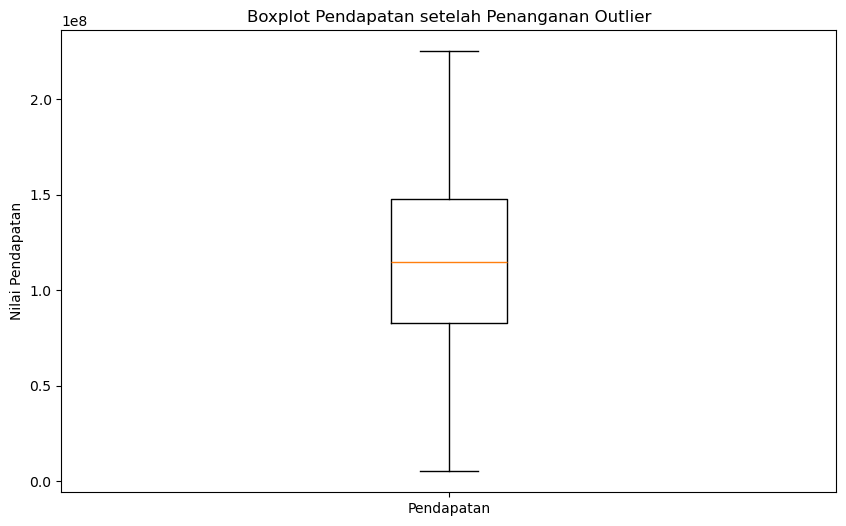

In [157]:
plt.figure(figsize=(10, 6))
plt.boxplot(trainFeatures['pendapatan'])
plt.ylabel('Nilai Pendapatan')
plt.title('Boxplot Pendapatan setelah Penanganan Outlier')
plt.xticks([1], ['Pendapatan'])
plt.show()